In [38]:
import torch
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import datetime as dt

from src.common.data import DataGenerator

In [39]:
# Ensure SurRender is running
generator = DataGenerator.from_robbins_dataset(resolution=2048, diamlims=(30, 500), arc_lims=0)

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [40]:
# Generate camera above Tycho (43.31°S 11.36°W) [https://en.wikipedia.org/wiki/Tycho_(lunar_crater)]

generator.set_coordinates(lat=-43.31, long=-11.36, convert_to_radians=True)
generator.scene_time = dt.datetime(2021, 2, 3, 12)
generator.height = 140
generator.point_nadir()
generator.solar_incidence_angle

69.68366967007213

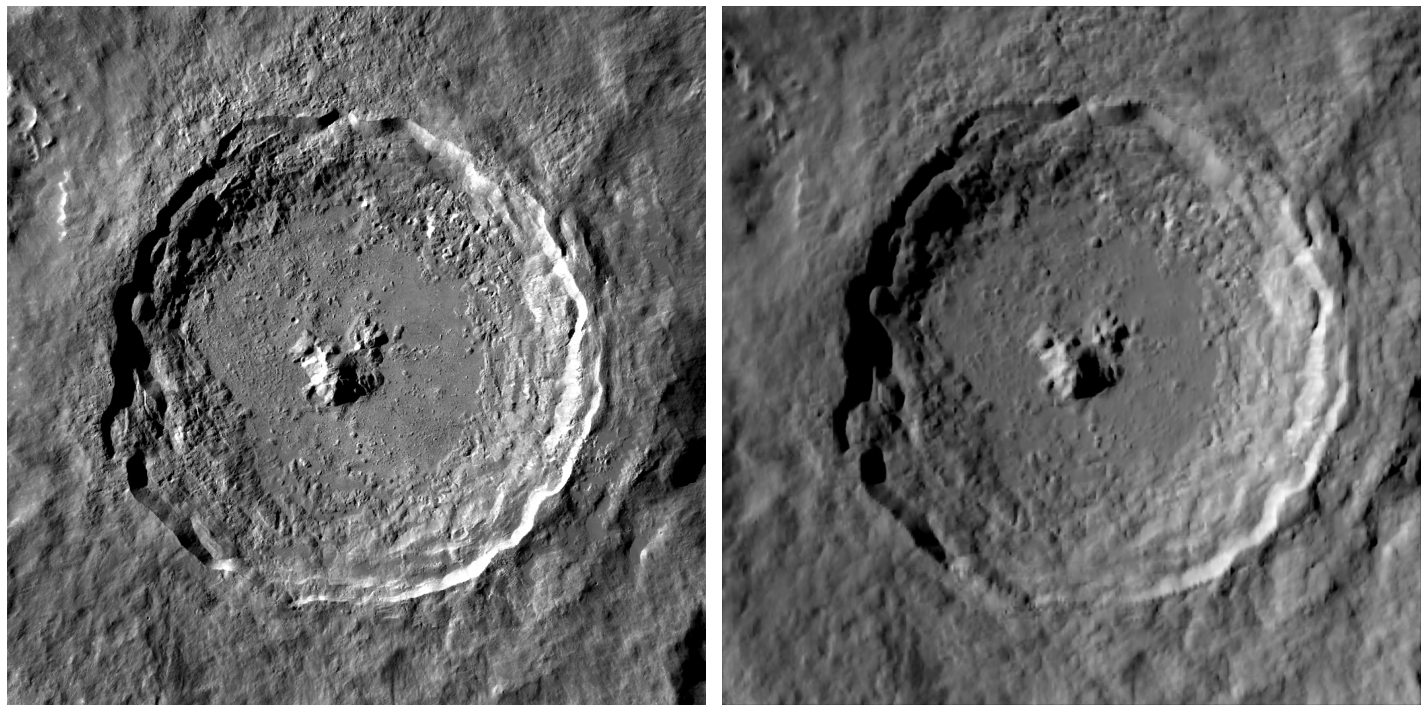

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

tycho_real = mpimg.imread('data/Tycho_LRO.png')
axes[0].imshow(tycho_real, cmap='gray')
axes[0].axis('off')

tycho_sim = generator.generate_image()
axes[1].imshow(tycho_sim, cmap='gray')
axes[1].axis('off')

fig.tight_layout()
# fig.savefig('diagrams/tycho_comparison.png')

In [42]:
# New scene
generator.set_coordinates(lat=0, long=180, convert_to_radians=True)
generator.scene_time = dt.datetime(2021, 1, 19, 12)
generator.height = 3000
generator.point_nadir()
generator.solar_incidence_angle

72.11468853248124

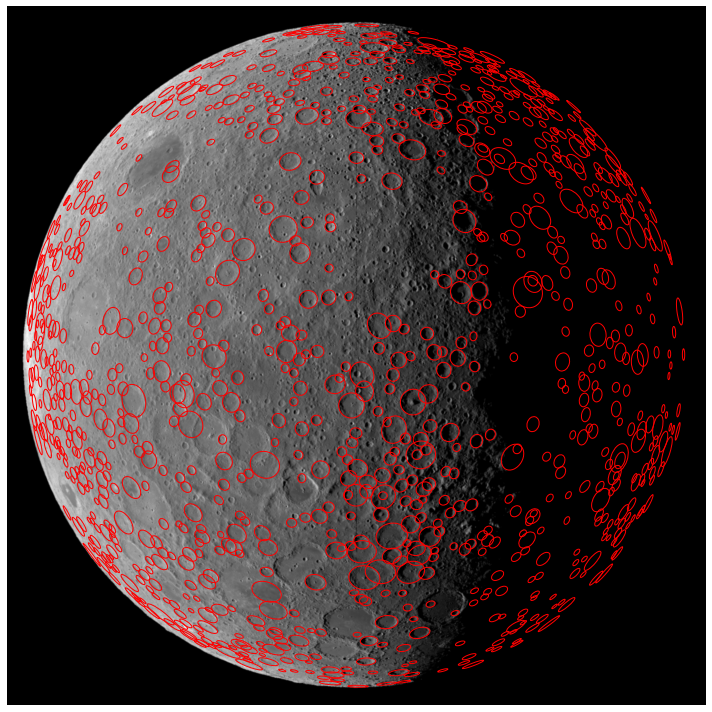

In [43]:
fig, ax= plt.subplots(figsize=(10, 10))

high_alt = generator.generate_image()
ax.imshow(high_alt, cmap='gray')
ax.axis('off')

generator.plot(ax=ax)

fig.tight_layout()
fig.savefig('diagrams/ellipse_plot_example.png')

In [48]:
generator = DataGenerator.from_robbins_dataset(resolution=512, diamlims=(15, 150), arc_lims=0, ellipse_limit=1.5)

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [49]:
generator.set_coordinates(lat=0, long=160, convert_to_radians=True)
generator.scene_time = dt.datetime(2021, 1, 19, 12)
generator.height = 500
generator.point_nadir()
generator.solar_incidence_angle

52.1188530140136

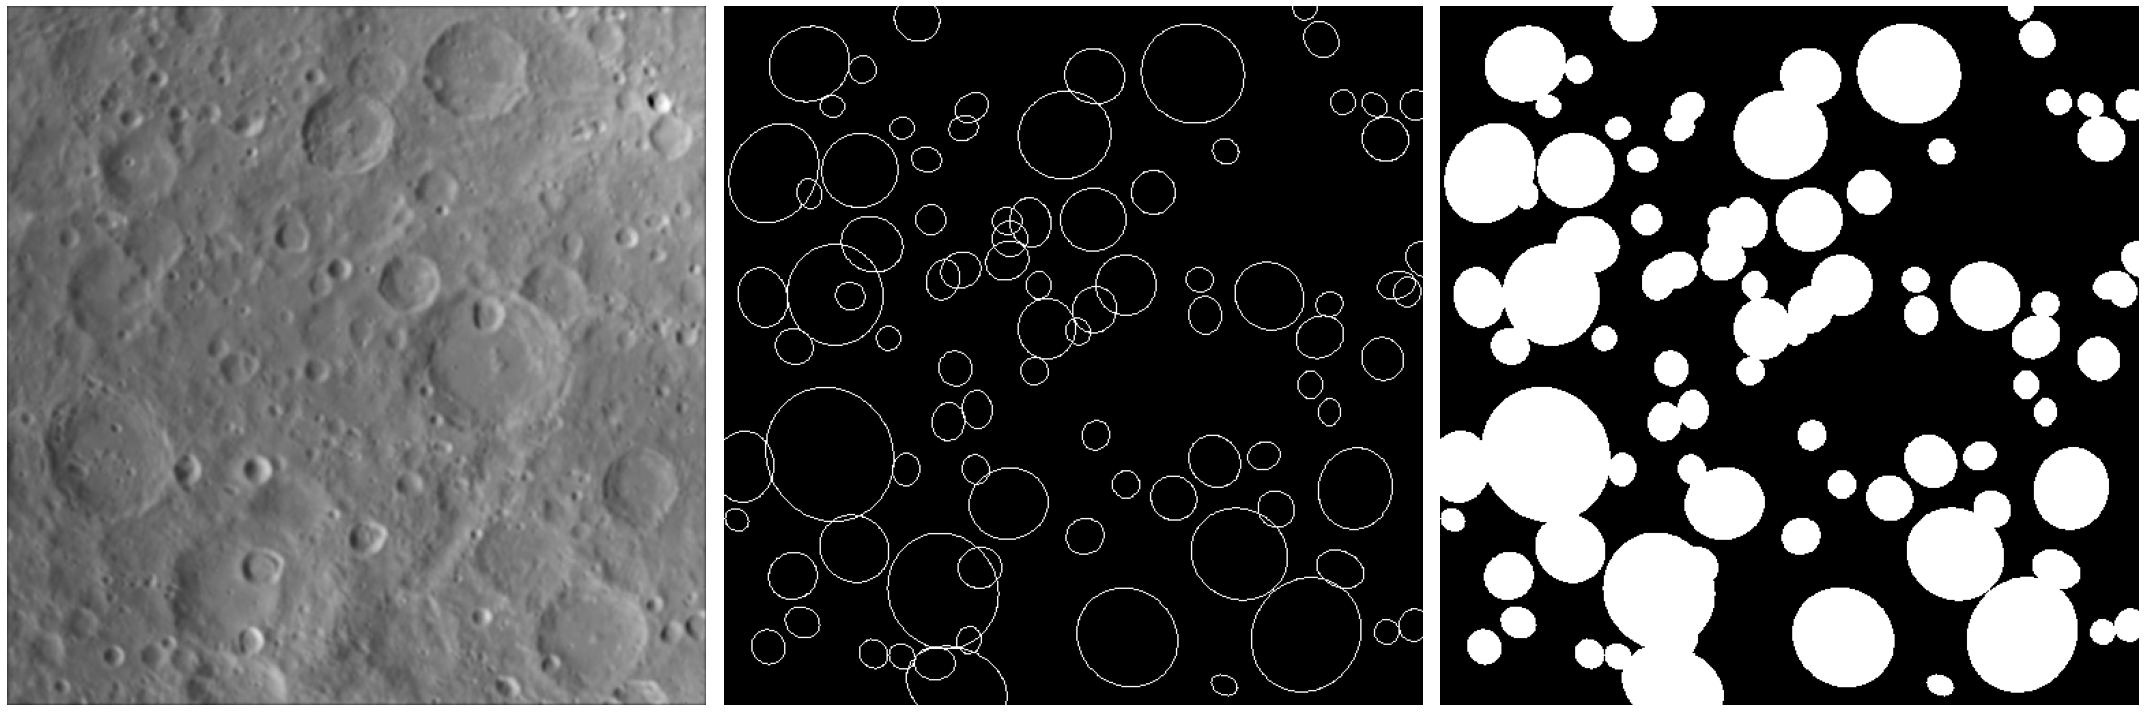

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

mask_demo_img, mask_edge = generator.image_mask_pair()
axes[0].imshow(mask_demo_img, cmap='gray')
axes[0].axis('off')


axes[1].imshow(mask_edge>0, cmap='gray')
axes[1].axis('off')

mask_filled = generator.generate_mask(filled=True)
axes[2].imshow(mask_filled>0, cmap='gray')
axes[2].axis('off')

fig.tight_layout()
fig.savefig('diagrams/image_mask_pair_demo.png')

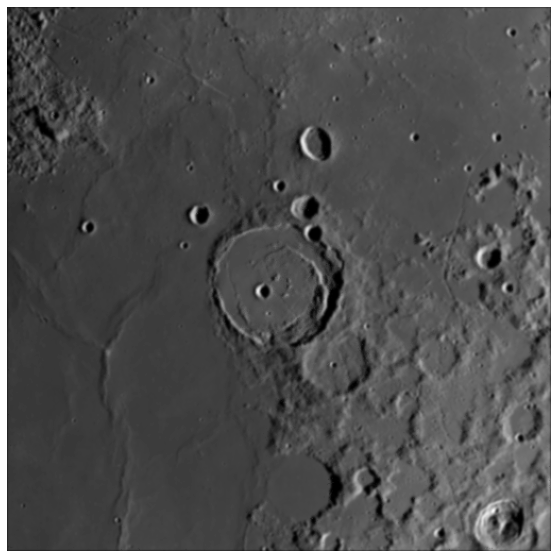

In [65]:
generator.set_coordinates(lat=32, long=30, convert_to_radians=True)
generator.scene_time = dt.datetime(2021, 1, 19, 19)
generator.height = 500
generator.point_nadir()

fig, ax = plt.subplots(figsize=(10, 10))

mask_demo_img = generator.generate_image()
ax.imshow(mask_demo_img, cmap='gray')
ax.axis('off')
fig.savefig("diagrams/crater_demo.png")

In [1]:
from src.detection.model import CraterDetector
from src.detection.training import CraterEllipseDataset, CraterMaskDataset, collate_fn
from torch.utils.data import DataLoader

import torch
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from common.conics import plot_conics, conic_center, scale_det
from detection.roi_heads import mv_kullback_leibler_divergence

In [47]:
ds = CraterEllipseDataset(file_path="data/dataset_crater_detection.h5", group="training")
loader = DataLoader(ds, batch_size=1, shuffle=True, num_workers=0, collate_fn=collate_fn)
model = CraterDetector(backbone_name="resnet50")
checkpoint = mlflow.pytorch.load_state_dict(r'artifacts/1/5fb01be998b34039b3fc3b129708cc24/artifacts/checkpoint')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

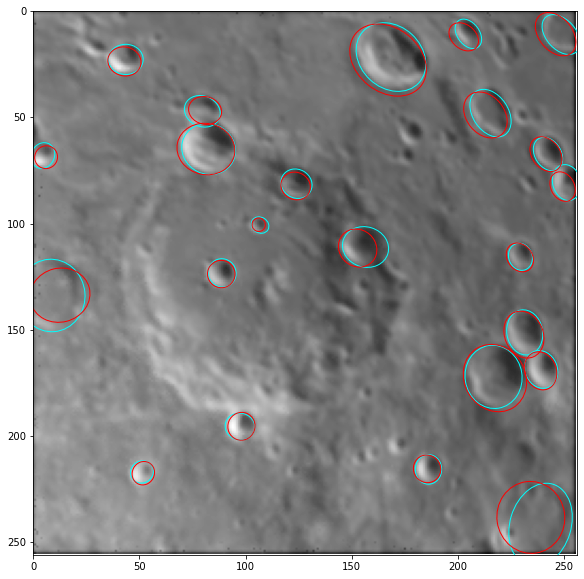

In [76]:
image, target = next(iter(loader))
model.eval()

A_craters_pred = model.get_conics(image, min_score=0.9)
A_craters_target = target[0]["ellipse_matrices"]

m_target = conic_center(target[0]["ellipse_matrices"])
m_pred = conic_center(A_craters_pred)

matched_idxs = torch.cdist(m_target, m_pred).argmin(0)

A_craters_target = A_craters_target[matched_idxs]
m_target = m_target[matched_idxs]

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(image[0][0].numpy(), cmap='gray')
plot_conics(A_craters_target.numpy(), ax=ax, rim_color='cyan')
plot_conics(A_craters_pred.numpy(), ax=ax)
# fig.savefig("diagrams/detection_sample.png")

In [57]:
A1, A2 = map(scale_det, (A_craters_pred, A_craters_target))
cov1, cov2 = map(lambda arr: arr[..., :2, :2], (A1, A2))
m1, m2 = map(lambda arr: torch.vstack(tuple(conic_center(arr).T)).T[..., None], (A1, A2))

trace_term = (torch.inverse(cov2) @ cov1).diagonal(dim2=-2, dim1=-1).sum(1)
log_term = torch.log(torch.det(cov2) / torch.det(cov1))

# displacement_term = ((m2 - m1).transpose(-1, -2) @ cov2.inverse() @ (m2 - m1)).squeeze()
displacement_term = 0
(0.5 * (trace_term + displacement_term - 2 + log_term)).mean()


tensor(0.0073)